In [6]:
import torchvision
import torch.nn as nn
import torch.nn.functional as nnf
import torch
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms.functional import to_tensor, normalize
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
from torchvision import transforms, models
from torchvision.datasets import Food101

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
print(torch.cuda.get_device_name(0))

def test_acc(net: nn.Module, test_loader: DataLoader):

  net.to(device)
  net.eval()
  
  total = 0
  correct = 0

  for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    total += labels.size(0)

    outputs = net(images)
    _, predicted = torch.max(outputs, 1)
    correct += (predicted == labels).sum().item()

  return correct / total * 100

def train_fn(epochs: int, train_loader: DataLoader, test_loader: DataLoader,
             net: nn.Module, loss_fn: nn.Module, optimizer: optim.Optimizer, train_dataset_length):

  losses = []
  accuracies = []

  net.to(device)

  for e in range(epochs):
    net.train()
    running_loss = 0.0

    for images, labels in train_loader:
      images, labels = images.to(device), labels.type(torch.LongTensor).to(device)

      optimizer.zero_grad()
      outputs = net(images)
      loss = loss_fn(outputs, labels)
      loss.backward()
      optimizer.step()

      running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / train_dataset_length

    print(f"Loss-ul la finalul epocii {e + 1}: {epoch_loss}")

    acc = test_acc(net, test_loader)
    print(f"Acuratetea la finalul epocii {e + 1} este {acc:.2f}%")

    losses.append(epoch_loss)
    accuracies.append(acc)

    torch.save(net.state_dict(), f'resnet50_multiplefclayers_adamw_epoch{e + 1}.pkl')

  loss_graph(losses)
  accuracy_graph(accuracies)

def loss_graph(losses):
    plt.plot(losses)

    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

def accuracy_graph(accuracies):
    plt.plot(accuracies)

    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.show()

cuda
NVIDIA GeForce RTX 4060 Laptop GPU


c:\Users\Vlad Talpiga.VLR_PROJAMZ\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Vlad Talpiga.VLR_PROJAMZ\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training started
Loss-ul la finalul epocii 1: 2.29452651389912
Acuratetea la finalul epocii 1 este 58.86%
Loss-ul la finalul epocii 2: 1.8379812729838658
Acuratetea la finalul epocii 2 este 62.38%
Loss-ul la finalul epocii 3: 1.7026732407371596
Acuratetea la finalul epocii 3 este 63.75%
Loss-ul la finalul epocii 4: 1.6321836477097111
Acuratetea la finalul epocii 4 este 65.33%
Loss-ul la finalul epocii 5: 1.5715858411600094
Acuratetea la finalul epocii 5 este 65.71%
Loss-ul la finalul epocii 6: 1.52705422123824
Acuratetea la finalul epocii 6 este 66.58%
Loss-ul la finalul epocii 7: 1.4919490164955063
Acuratetea la finalul epocii 7 este 67.04%
Loss-ul la finalul epocii 8: 1.4527476415728577
Acuratetea la finalul epocii 8 este 67.49%
Loss-ul la finalul epocii 9: 1.4237017895097386
Acuratetea la finalul epocii 9 este 67.98%
Loss-ul la finalul epocii 10: 1.3929160910502518
Acuratetea la finalul epocii 10 este 68.17%
Loss-ul la finalul epocii 11: 1.37244563452088
Acuratetea la finalul epocii

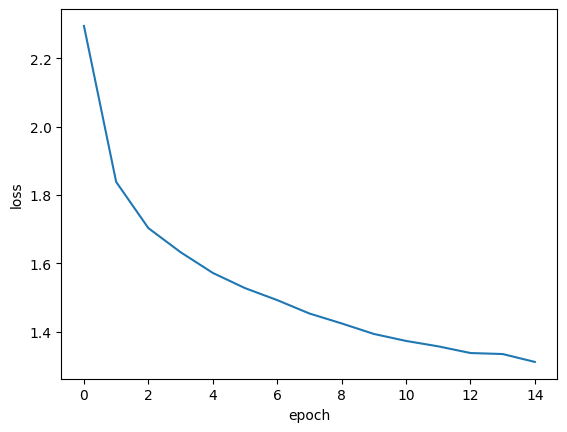

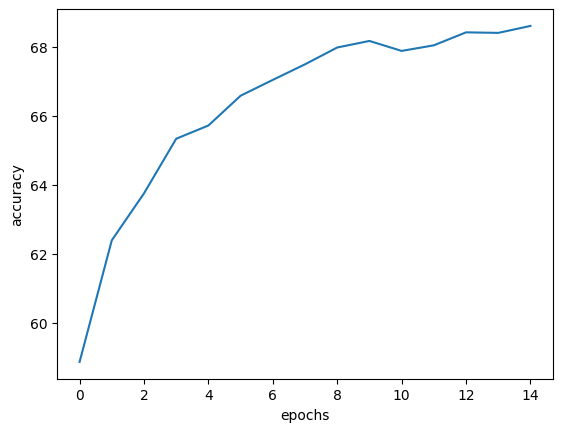

Duration of training: 430.1640294710795


In [7]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the datasets
train_dataset = Food101(root='C:/Users/Vlad Talpiga.VLR_PROJAMZ/OneDrive - Valrom Industrie SRL/Desktop/IAVA/Proiect/FoodClassifier/data', split='train', transform=transform, download=True)
test_dataset = Food101(root='C:/Users/Vlad Talpiga.VLR_PROJAMZ/OneDrive - Valrom Industrie SRL/Desktop/IAVA/Proiect/FoodClassifier/data', split='test', transform=transform, download=True)

# Create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class CustomClassifier(nn.Module):
    def __init__(self, num_classes):
        super(CustomClassifier, self).__init__()

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.classifier(x)

num_classes = len(train_dataset.classes)
resnet = models.resnet50(pretrained=True)
resnet = nn.Sequential(*list(resnet.children())[:-1])

# Freeze all layers except the final classification layer
for param in resnet.parameters():
    param.requires_grad = False

resnet = nn.Sequential(
    resnet,
    CustomClassifier(num_classes)
)

# print(*list(resnet.children()))

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=0.001, momentum=0.99, weight_decay=0.00001)

epochs = 15
start = time.time()
print('Training started')

train_fn(epochs, train_loader, test_loader, resnet, loss_fn, optimizer, len(train_dataset))

end = time.time()
print(f'Duration of training: {(end - start) / 60}')